In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from datetime import datetime
import re
from os.path import expanduser

# Get libertine font
from matplotlib.font_manager import _rebuild; _rebuild()
import matplotlib.font_manager as font_manager
# ??plt.use('Agg')
fontpath = expanduser('~/Library/Fonts/LinLibertine_R.otf')
print('fontpath', fontpath)
prop = font_manager.FontProperties(fname=fontpath)
plt.rcParams['font.family'] = prop.get_name()
plt.rcParams['text.usetex'] = False

print(len(font_manager.findSystemFonts()))


%matplotlib inline

fontpath /Users/fboemer/Library/Fonts/LinLibertine_R.otf
216


In [25]:
def parse_results(file_name):

    re_time = r'.*Total time (.*) \(ms\)'
    
    runtime = None
    with open(file_name) as f:
        lines = [line.strip() for line in f.readlines()]
        for line in lines:
            #print(line)
            if re.match(re_time, line):
                match = re.match(re_time, line)
                runtime = float(match.groups()[0])
                
    if runtime is None:
        print('could not find runtime in ', file_name)
    assert(runtime is not None)
    
    return runtime

def parse_results_and_accs(file_name):

    re_time = r'.*Total time (.*) \(ms\)'
    re_top1 = r'top1_acc (.*)'
    re_top5 = r'top5_acc (.*)'
    top1 = None
    top5 = None
    
    runtime = None
    with open(file_name) as f:
        lines = [line.strip() for line in f.readlines()]
        for line in lines:
            #print(line)
            if re.match(re_time, line):
                match = re.match(re_time, line)
                runtime = float(match.groups()[0])
            elif re.match(re_top1, line):
                match = re.match(re_top1, line)
                top1 = float(match.groups()[0])
            elif re.match(re_top5, line):
                match = re.match(re_top5, line)
                top5 = float(match.groups()[0])
                
    if runtime is None:
        print('could not find runtime in ', file_name)
    if top1 is None:
        print('could not find top1 acc in ', file_name)
    if top5 is None:
        print('could not find top5 acc in ', file_name)
    assert(runtime is not None)
    assert(top1 is not None and top5 is not None)
    
    return top1, top5, runtime

def parse_accs(file_name):    
    runtime = None
    with open(file_name) as f:
        lines = [line.strip() for line in f.readlines()]
        for line in lines:
            #print(line)
            if re.match(re_top1, line):
                match = re.match(re_top1, line)
                top1 = float(match.groups()[0])
            elif re.match(re_top5, line):
                match = re.match(re_top5, line)
                top5 = float(match.groups()[0])
                
    if top1 is None:
        print('could not find top1 acc in ', file_name)
    if top5 is None:
        print('could not find top5 acc in ', file_name)
    assert(top1 is not None and top5 is not None)
    
    return top1, top5


top1 {96: 42.3437, 128: 50.0, 160: 56.223, 192: 58.684100000000015, 224: 60.43220000000001}
top5 {96: 67.1509, 128: 74.4, 160: 79.7094, 192: 81.3086, 224: 82.74640000000001}
035-96 & 42.3 & 67.2 & 27 & 112 \pm 5 & 92 & 376 \\ 
035-128 & 50.0 & 74.4 & 46 & 187 \pm 4 & 116 & 477 \\ 
035-160 & 56.2 & 79.7 & 71 & 290 \pm 7 & 200 & 818 \\ 
035-192 & 58.7 & 81.3 & 103 & 422 \pm 23 & 276 & 1130 \\ 
035-224 & 60.4 & 82.7 & 129 & 529 \pm 18 & 382 & 1564 \\ 


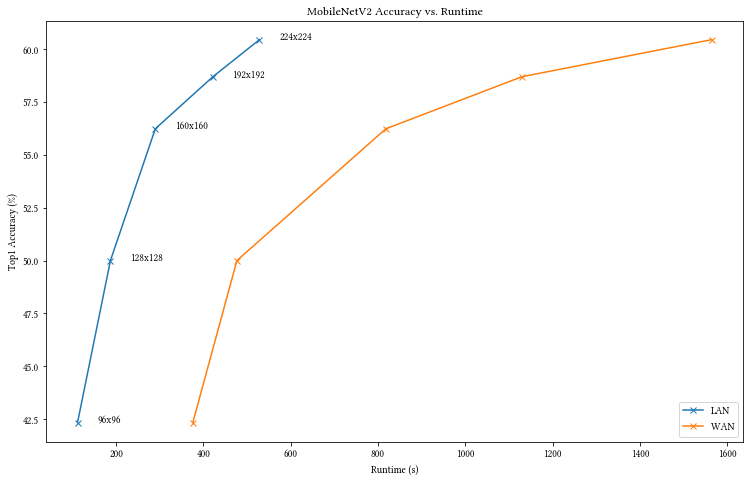

In [34]:
def make_mobilenet_table():
    batch_size = 4096.
    
    folder = './results/'
        
    sizes = [96, 128, 160, 192, 224]
    
    def parse_lan_time_and_acc_results():
        lan_results = {}
        top1 = {}
        top5 = {}
        
        for size in sizes:
            lan_times_ms = []
            top1_accs = []
            top5_accs = []
            
            for trial in range(1,11):
                name = '035_' + str(size) + '_clientless_' + str(trial)
                filename = folder + name + '.txt'
                
                top1_acc, top5_acc, lan_time_ms = parse_results_and_accs(filename)
                lan_times_ms.append(lan_time_ms)
                top1_accs.append(top1_acc)
                top5_accs.append(top5_acc)
            
            lan_results[size] = lan_times_ms
            top1[size] = np.mean(top1_accs)
            top5[size] = np.mean(top5_accs)
        
        return top1,top5, lan_results    
        
    # 96: 42.3437, 128: 27.182500000000005, 160: 56.223, 192: 58.684100000000015, 224: 60.43220000000001
    #top1_accs = {96: 42.4, 128:50.0, 160:56.2, 192:58.6, 224:60.4}
    
    top1_accs, top5_accs, lan_results = parse_lan_time_and_acc_results() #{96:109, 128:175, 160:263, 192:393, 224:507}
    
    top1_accs[128] = 50.0
    top5_accs[128] = 74.4
    
    print('top1', top1_accs)
    print('top5', top5_accs)
    
    def parse_wan_results():
       

        names = ['035_96_wan_test',
                 '035_128_wan_test',
                 '035_160_wan_test',
                 '035_192_wan_test',
                 '035_224_wan_test']
       
        wan_times_s = {}
        lan_times_s = {}

        for size in sizes:
            name = '035_' + str(size) + '_wan_test'
            filename = folder + name + '.txt'
            wan_time_ms = parse_results(filename)
            wan_time_s = wan_time_ms / 1000.
            
            wan_amt_time_ms = int(np.round(wan_time_ms / batch_size))            
            wan_time_s = int(np.round(wan_time_s,0))
            
            lan_time_ms = lan_results[size]
            lan_time_s = [t / 1000. for t in lan_time_ms]
            avg_lan_time_s = np.mean(lan_time_s)
            std_lan_time_s = np.round(np.std(lan_time_s))
            avg_lan_time_ms = np.mean(lan_time_ms)
            lan_amt_time_ms = int(np.round(avg_lan_time_ms / batch_size))        
                        
            table_str = name.strip('_wan_test').replace('_','-') + ' & ' \
                + str(np.round(top1_accs[size], 1)) + ' & ' \
                + str(np.round(top5_accs[size], 1)) + ' & ' \
                + str(lan_amt_time_ms) + ' & ' + str(int(np.round(avg_lan_time_s))) + ' \\pm ' \
                + str(int(std_lan_time_s)) + ' & ' \
                + str(wan_amt_time_ms) + ' & ' + str(wan_time_s) + ' \\\\ '
                    
            wan_times_s[size] = wan_time_s
            lan_times_s[size] = lan_time_s
                
            print(table_str)

        #print('wan_times_s', wan_times_s)
        #print('lan_times_s', lan_times_s)
        
        
        
        lan_x_vals = [np.mean(lan_times_s[size]) for size in sizes]
        wan_x_vals = [wan_times_s[size] for size in sizes]
        y_vals = [top1_accs[size] for size in sizes]
        
        #plt.rcParams.update({'font.size': 22})        
        plt.plot(lan_x_vals, y_vals, label='LAN', marker='x')
        plt.plot(wan_x_vals, y_vals, label='WAN', marker='x')
        
        for size in sizes:
            plt.text(np.mean(lan_times_s[size])+45, top1_accs[size], str(size)+'x'+str(size))
        
        plt.legend(loc='lower right')
        plt.xlabel('Runtime (s)')
        plt.ylabel('Top1 Accuracy (%)')
        plt.title('MobileNetV2 Accuracy vs. Runtime')
        fig = plt.gcf()
        fig.set_size_inches(12.5, 7.75)
        #fig = plt.gcf()
        fig.savefig('mobilenet_plot.png', dpi=300, bbox_inches='tight')
        #plt.show()
        
    
    parse_wan_results()
    
make_mobilenet_table()

In [22]:
def old_slow_results():
    def make_mobilenet_table():
        results = parse_mobilenet_results()


    def parse_mobilenet_results():
        folder = './results/'

        names = ['035_96_1',
                 '035_128_1',
                 '035_160_1',
                 '035_192_1',
                 '050_96_1',
                 '050_128_1',
                 '050_192_1']

        times = {}

        for name in names:
            filename = folder + name + '.txt'
            time = parse_results(filename)
            print(name, time)
            times[name] = time

        return times

    make_mobilenet_table()

In [34]:
def parse_old_results():
    folder = './results/'
    best_times = []
    omp1_complex_times = []
    omp1_times = []
    for i in range(1,11):
        best_file = folder + 'best_' + str(i) + '.txt'
        best_time = parse_results(best_file)
        best_times.append(best_time)

    if False:
        for i in range(1,11):   
            omp1_complex_file = folder + 'omp1_complex_' + str(i) + '.txt'
            omp1_complex_time = parse_results(omp1_complex_file)
            omp1_complex_times.append(omp1_complex_time)

        for i in range(1,11):
            omp1_file = folder + 'omp1_' + str(i) + '.txt'
            omp1_time = parse_results(omp1_file)
            omp1_times.append(omp1_time)


    def fmt_line(times, batch_size):
        times_sec = [time / 1000. for time in times]
        amortized_time_ms = np.round(np.mean(times) / batch_size, 2)

        ret = str(amortized_time_ms) + ' & '
        ret += '$' +str(np.round(np.mean(times_sec), 2)) + ' \pm ' + str(np.round(np.std(times_sec), 2)) + '$ \\tabularnewline'
        return ret

    if False:
        print('omp1_times')
        print(fmt_line(omp1_times, 1024))

        print('omp1_complex_times')
        print(fmt_line(omp1_complex_times, 2048))

    print('best_times')
    print(fmt_line(best_times, 2048))
    
parse_old_results()    


FileNotFoundError: [Errno 2] No such file or directory: './results/best_1.txt'

In [32]:
def make_table(best_times, omp1_times, naive_times):
    return

In [33]:
for i in range(1,11):
    omp1_file = folder + 'omp1_' + str(i) + '.txt'
    omp1_time = parse_results(omp1_file)
    omp1_times.append(omp1_time)

NameError: name 'folder' is not defined

# TF accuracies

In [55]:
def parse_tf_accuracies(file_name):

    re_top1 = r'top1_acc (.*)'
    re_top5 = r'top5_acc (.*)'
    
    top1_acc = None
    top5_acc = None
    
    runtime = None
    with open(file_name) as f:
        lines = [line.strip() for line in f.readlines()]
        for line in lines:
            #print(line)
            if re.match(re_top1, line):
                match = re.match(re_top1, line)
                top1_acc = float(match.groups()[0])
            elif re.match(re_top5, line):
                match = re.match(re_top5, line)
                top5_acc = float(match.groups()[0])
                
    if top1_acc is None:
        print('could not find top1_acc in ', file_name)
    if top5_acc is None:
        print('could not find top5_acc in ', file_name)
    #assert(top1_acc is not None)
    #assert(top5_acc is not None)
    
    return (top1_acc, top5_acc)


In [56]:
def get_tf_accuracies(image_sizes, expansion_factors):
    folder = './results/'

    accuracies = {}

    for factor in expansion_factors:
        accuracies[factor] = {}

        for size in image_sizes:
            suffix = 'acc_' + factor + '_' + str(size) + '.txt'
            filename = folder + suffix
            top1, top5 = parse_tf_accuracies(filename)

            accuracies[factor][size] = {}
            accuracies[factor][size][1] = top1
            accuracies[factor][size][5] = top5

    print(accuracies)
    return accuracies

In [57]:
def make_tf_accuracies_table(accuracies, image_sizes, expansion_factors):
    for factor in expansion_factors:
        for size in image_sizes:
            factor_str = factor.replace('0', '0.', 1)
            model_name = factor_str + '-' + str(size)
            model_name = model_name.replace('0-','-')
            top1 = np.round(accuracies[factor][size][1], 1)
            top5 = np.round(accuracies[factor][size][5], 1)
            
            table_str = model_name + ' & ' + str(top1) \
                                   + ' & ' + str(top5) \
                                   + ' & ' + ' & \\\\ ' 
            
            
            print(table_str)

In [58]:
image_sizes = [96, 128, 160, 192, 224]
expansion_factors = ['035','050', '075']

accuracies = get_tf_accuracies(image_sizes, expansion_factors)
make_tf_accuracies_table(accuracies, image_sizes, expansion_factors)

could not find top1_acc in  ./results/acc_075_224.txt
could not find top5_acc in  ./results/acc_075_224.txt
{'035': {96: {1: 42.37, 5: 67.106}, 128: {1: 50.032, 5: 74.382}, 160: {1: 56.202, 5: 79.73}, 192: {1: 58.582, 5: 81.252}, 224: {1: 60.384, 5: 82.75}}, '050': {96: {1: 48.462, 5: 73.12}, 128: {1: 56.326, 5: 79.604}, 160: {1: 60.422, 5: 82.896}, 192: {1: 63.686, 5: 85.158}, 224: {1: 65.53, 5: 86.368}}, '075': {96: {1: 54.882, 5: 78.802}, 128: {1: 61.716, 5: 83.884}, 160: {1: 65.566, 5: 86.664}, 192: {1: 68.73, 5: 88.662}, 224: {1: None, 5: None}}}
0.35-96 & 42.4 & 67.1 &  & \\ 
0.35-128 & 50.0 & 74.4 &  & \\ 
0.35-160 & 56.2 & 79.7 &  & \\ 
0.35-192 & 58.6 & 81.3 &  & \\ 
0.35-224 & 60.4 & 82.8 &  & \\ 
0.5-96 & 48.5 & 73.1 &  & \\ 
0.5-128 & 56.3 & 79.6 &  & \\ 
0.5-160 & 60.4 & 82.9 &  & \\ 
0.5-192 & 63.7 & 85.2 &  & \\ 
0.5-224 & 65.5 & 86.4 &  & \\ 
0.75-96 & 54.9 & 78.8 &  & \\ 
0.75-128 & 61.7 & 83.9 &  & \\ 
0.75-160 & 65.6 & 86.7 &  & \\ 
0.75-192 & 68.7 & 88.7 &  & \\ 


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'